# SARIMA Tahmini

## 01 - Arka Plan

Bu challenge'daki amacımız zaman serisi analizinin temel kavramlarını tek boyutlu veriye (tarihe bağlı satışlar) uygulamaktır.

Bu challenge'da şu adımları takip edeceğiz:
1. veriyi yükle ve görselleştir;
2. modellerimizi eğit ve tahminler yap;
3. seriyi modellemek ve tahmin edebilmek için ekonometrik yaklaşım kullan;
4. bu modeli hacklemek için Makine Öğrenmesi kullan.

Veri seti [Machine Learning Mastery](https://github.com/jbrownlee/)'nin izniyle kullanılmaktadır. İndirmek için aşağıdaki satırı çalıştırın!

In [2]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1596  100  1596    0     0   8592      0 --:--:-- --:--:-- --:--:--  8580


## 02 - Veri Yükleme
Challenge'ın zaman serisini yükleyerek başlayalım

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 DataFrame'in "Month" sütununu `Datetime` nesnelerine dönüştürün ve şöyle görünmesi için index olarak ayarlayın:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [3]:
# First, convert the column to Datetime
df["Month"] = pd.to_datetime(df["Month"], infer_datetime_format=True)

# Next, we reset the index and set it to the Month column
df = df.set_index(df["Month"])

# Now we no longer need the original column, so we drop it
df = df.drop("Month", axis=1)

df.head()

/var/folders/dt/9ml5qx0s6n7c30jndl23_3r40000gn/T/ipykernel_30975/3846107846.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["Month"] = pd.to_datetime(df["Month"], infer_datetime_format=True)


,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


### Alternatif - Pandas'ın İşi Yapmasına İzin Ver

In [5]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Veriyi Görselleştir ve Yorumla

Aferin, bu yeniden indeksleme sayesinde artık "Sales" (y-ekseni) değerlerini zaman (x-ekseni) fonksiyonu olarak kolayca çizebilmelisiniz

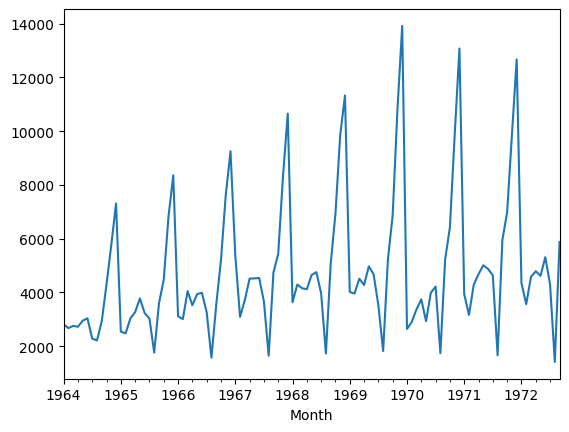

In [6]:
df["Sales"].plot();

Kodunuz doğruysa, bu zaman serisinin (TS) şunları gösterdiğini görebilmelisiniz:
- Durağan değil (ortalama ve varyans sabit değil).
- Güçlü mevsimsellik sergiliyor.
- Bir trend var gibi görünüyor.

Verinin **trend**, **mevsimsellik** ve **gürültü** arasındaki ayrışmasını görelim. Bunun için statsmodels'ın [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) fonksiyonunu kullanmanız gerekiyor. Dokümantasyonu okuyun ve bu fonksiyonun ne yaptığını ve nasıl kullanıldığını anladığınızdan emin olun, sonra:
1. "Sales" verisini "additive" model ile çizin
2. "Sales" verisini "multiplicative" model ile çizin

İpucu: statsmodels çizim metot çağrılarınızı noktalı virgülle (`;`) bitirin, böylece çift çizim sorunlarından kaçınırsınız!

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_add = seasonal_decompose(df["Sales"], model="additive")
decomp_mult = seasonal_decompose(df["Sales"], model="multiplicative")

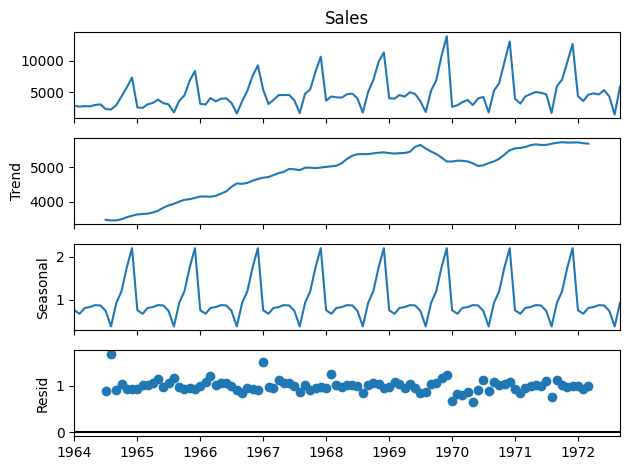

In [8]:
decomp_mult.plot();

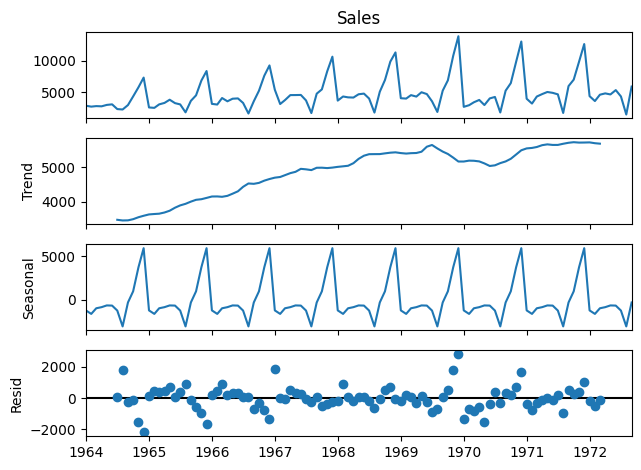

In [9]:
decomp_add.plot();

👉 Seçtiğiniz ayrışımı kullanarak bu zaman serisini mevsimsellikten arındırın

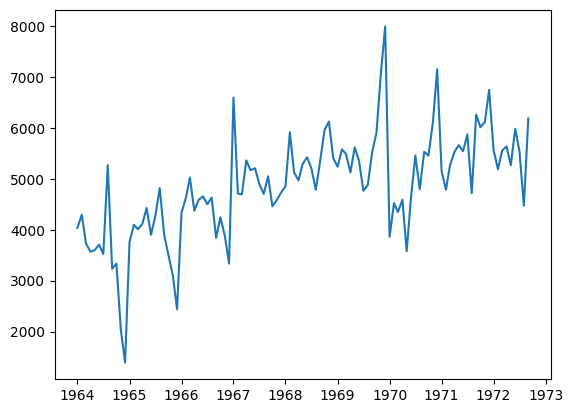

In [10]:
plt.plot(df.Sales - decomp_add.seasonal);

☝️ Bu zaman serisinin "mevsimsellikten arındırılmış" versiyonuna bir ARIMA modeli uydurabilir ve tahminimizden sonra yeniden kompoze edebilirdik. Ancak bu challenge'da orijinal zaman serisini _doğrudan_ uydurmak için SARIMA modellerini kullanacağız!

## 05 - Veriyi Böl (eğitim/test)

Zaman serileri için test setinde olmak üzere noktaları rastgele örnekleyemeyiz. Test seti "zaman dışı" olmalıdır, yani test setinin kesinlikle geleceğinde olmalıdır. Bu alıştırma için eğitim için 1970'e kadarki veriyi kullanacağız ve sonraki her şey (veya eşit) test için kullanılacak.

👉 `df_train` ve `df_test` oluşturun, DataFrame'i eğitim için 1970'ten önce, test için sonra (veya eşit) bölerek

In [11]:
df_train = df[:'1969']
df_test = df['1970':]
print(df_train.shape)
print(df_test.shape)

(72, 1)
(33, 1)


In [12]:
print("train shape: {}, test shape: {}".format(df_train.shape,df_test.shape))

train shape: (72, 1), test shape: (33, 1)


## 06 - SARIMA
Veriyi SARIMA modeli (Seasonal Auto-Regressive Integrated Moving Average - Mevsimsel Oto-Regresif Entegre Hareketli Ortalama) kullanarak analiz edeceğiz.

Şunları bulmamız gerekiyor:
- zaman serisini nasıl durağanlaştıracağız (SARIMA'daki I)
- oto-regresif (AR) kısmını bul
- hareketli ortalama (MA) kısmını bul
- mevsimselliği (S) bul

### Adım 1: Durağanlığı Kontrol Et

Bir zaman serisi trend veya mevsimsellik bileşeni içeriyorsa, tahmin için ARIMA kullanabilmeden önce durağan hale getirilmesi gerekir.

Yukarıdaki grafiğe bir bakış, zaman serisinin durağan olmadığına ikna etmek için yeterli olmalıdır.

[`Augmented Dickey Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) ve özellikle p-değerini kullanarak `df["Sales"]`'ın durağanlığını iki kez kontrol edin

In [13]:
from statsmodels.tsa.stattools import adfuller

print('p-value: ', adfuller(df_train["Sales"])[1])

p-value:  0.7753855460224304


Durağanlıkta %95 güven için p-değeri 0.05'ten küçük olmalıdır.

P-değeri 0.05'ten büyükse, boş hipotezi reddedemeyiz (boş hipotez = "süreç durağan değildir").

İdeal olarak, p 0.05'ten *çok* küçüktür.

Durağanlığa bakmanın başka bir yolu otokorelasyon fonksiyonuna (ACF) bakmaktır.

Zaman serisinin ACF'sini çizin. Lag 12'de büyük bir pik görmelisiniz, bu güçlü yıllık mevsimselliği gösterir.

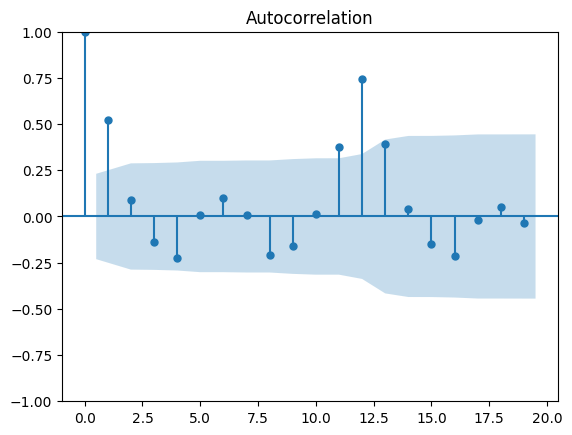

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = df_train.Sales
plot_acf(y);

### Adım 2 - Mevsimsel Farklandırma (D)

12 aylık periyotla güçlü mevsimselliğimiz var.

Zaman serisinde **12 lag'li mevsimsel farklandırma** yapın, farklandırılmış veriyi çizin ve ACF grafiğini (+ADF testi) tekrar kontrol edin.

NaN'ları düşürmeyi unutmayın.

p-value:  2.6473506362550414e-09


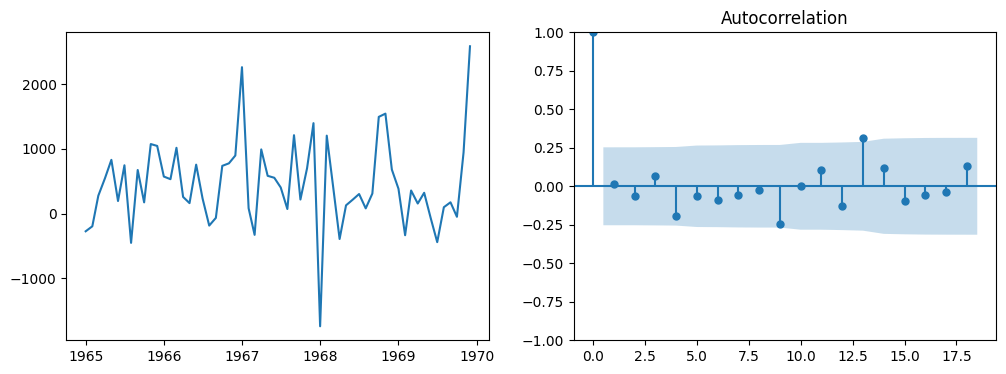

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

y_diff_12 = df_train.Sales.diff(12).dropna()

axes[0].plot(y_diff_12)
plot_acf(y_diff_12, ax=axes[1])

print('p-value: ', adfuller(y_diff_12)[1])

☝️ Tek bir mevsimsel farklandırma TS'yi durağanlaştırmak için yeterli görünüyor.
SARIMA(p,d,q, P,D,Q,m) için D=1 (1 mevsimsel fark) ve m=12 (mevsimsellik = 12)

### Adım 3 - Farklandırma (d)

Zaman serisi hala durağan değilse, *farklandırma* yoluyla durağanlaştırılması gerekir. Bu, her değer ile önceki değer arasındaki farkı aldığımız anlamına gelir (*birinci fark*).

Mevsimselliği çıkardıktan sonra daha fazla farklandırmaya ihtiyacımız var mı?

Diff(12) serinizde ek bir birinci derece diff(1) çalıştırdıktan sonra ACF ve ADF'yi kontrol edin.

p-value:  0.0005183923752540941


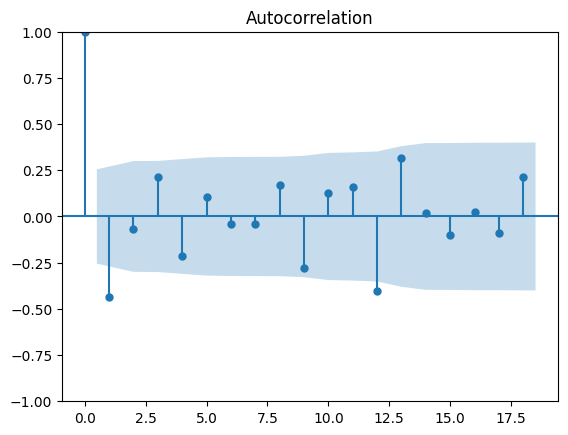

In [16]:
plot_acf(y_diff_12.diff(1).dropna());
print('p-value: ', adfuller(y_diff_12.diff(1).dropna())[1])

👉 Ek farklandırma hem p-değerini hem de ACF'yi daha kötü hale getirdi!
(d=0) ve (D=1) seçebiliriz

### Adım 4 - AR(p, P) ve MA(q, Q) Terimlerini Seç

Şimdi AR terim(ler)i, MA terim(ler)i veya her ikisini dahil edip etmemeye karar vermek için ACF ve PACF grafiklerini kullanacaksınız.

- **Tam farklandırılmış** serinize uygulanan otokorelasyon grafiği ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) MA numarası (`q`) seçmenizi sağlar
- MA($\color{blue}{q}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{blue}{ACF}$'sinin kesildiği lag sayısı


- **Tam farklandırılmış** serinize uygulanan kısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) AR (`p`) seçmenizi sağlar
- AR($\color{red}{p}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{red}{PACF}$'sinin kesildiği lag sayısı

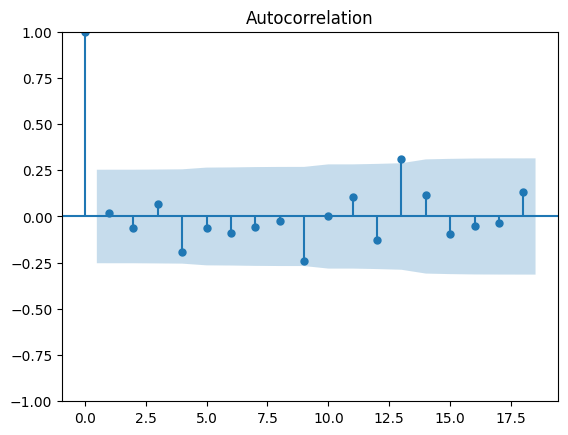

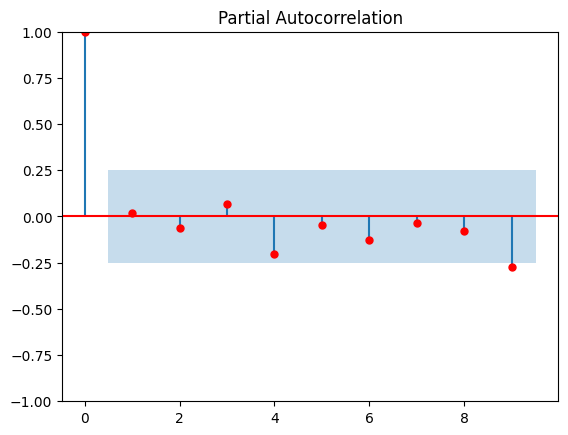

In [22]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y_diff_12);
plot_pacf(y_diff_12, lags=np.arange(10), method='ywm',c='red');

☝️ ACF veya PACF'de önemli pik yok gibi görünüyor, bu yüzden büyük olasılıkla p=q=0.
SARIMA için ilk tahminimiz dolayısıyla d=0, p=q=0, D=1 ve m=12.

P ve Q değerlerini nasıl bulacağız? Burada `pmdarima`'nın bizim için grid_search ile P ve Q için 1 ve 0 değerlerini denemesine izin vereceğiz.
Bu katsayıları kendiniz bulmak istiyorsanız, bazı temel kurallar için [bunu okuyun](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/)

👉 Eğitim seti için [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) çalıştırın. seasonal=True, m=12 ve D=1 ayarlayın. p ve q, P ve Q için 0'dan 2'ye kadar arama yapın. Sonra model.summary() ile modelin özetini yazdırın.
`njobs=-1, trace=True, error_action='ignore', suppress_warnings=True` kullanın

In [23]:
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'

In [19]:
model = pm.auto_arima(
    df_train['Sales'],
    m=12, # frequency of series. Important to choose manually
    seasonal=True,
    stepwise=True,  # only check the most interesting combination. False will take way longer.
    start_p=0, max_p=2,
    start_d=0, max_d=1,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_D=0, max_D=2,
    start_Q=0, max_Q=2,
    njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

NameError: name 'pm' is not defined

Bulunan en iyi model `ARIMA(0,0,0)(0,1,0)[12]`!
Bu, ele alınan zaman serisinin basit "mevsimsel farklandırma"nın ötesinde herhangi bir "oto-regresif" veya "hareketli ortalama" modellemesi eklemeyi haklı çıkarmadığı anlamına gelir.

Böyle "zayıf" bir model, muhtemelen sadece tespit edilen son mevsimsel kalıbın tekrarını ve ortalama artan trendin uzatılmasını tahmin edebilir. Kontrol edelim

👉 `n_periods` = test setinin uzunluğu ile `model.predict` kullanarak aşağıdaki üç tahmini kaydedin:
- `central`
- `upper`
- `lower`

Bunları Pandas Series olarak kaydedin ve `y_test` ile aynı indeks ile indeksleyin

In [ ]:
# Forecast
n_periods = len(df_test)
central, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# Make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(conf_int[:, 0], index=index_y_test)
upper = pd.Series(conf_int[:, 1], index=index_y_test)

👇 Tahminlerinizi gerçeklerle karşılaştırmak için aşağıdaki hücreyi çalıştırın

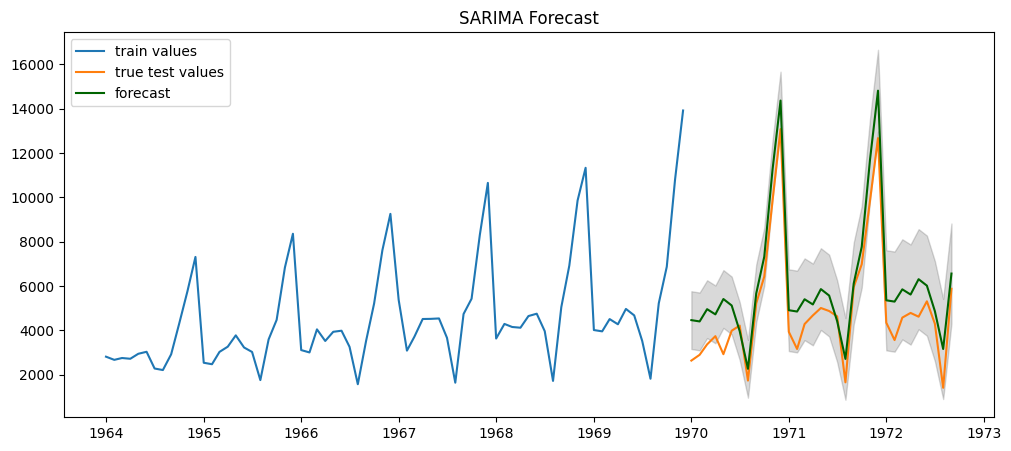

In [ ]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color='k', alpha=.15
)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 SARIMA'nızda `p`, `d`, `P`, `D`'ye sıfır olmayan değerler atamayı deneyin ve etkileri karşılaştırmak için bu grafiği yeniden çizin!

# İSTEĞE BAĞLI - Makine Öğrenmesi Yaklaşımı

### Tahmin ufku = sadece 1 ay olan Model

Şimdi Random Forest gibi doğrusal olmayan bir model uyduracağız. Fikir, son değerlerden bir değer tahmin etmektir.

👉 `df`'de `df['Sales']`'ın kaydırılmış versiyonu olan yeni sütunlar oluşturun. Bunu 1'den 12'ye kadar kaydırma ile yapın.

In [ ]:
# Add lagged values
df2 = df.copy()
for i in range(1, 13):
    df2[f'x_{i}'] = df["Sales"].shift(i)

# Drop nan
df2 = df2.dropna()

# create df_train and df_test
df2_train = df2[:'1969']
df2_test = df2['1970':]

In [ ]:
# Keep track of test_indexes
test_indexes = np.arange(len(df2_train), len(df2_train)+len(df2_test))
test_indexes

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92])

In [ ]:
# Create X, y
y = df2['Sales']
X = df2.drop(columns=['Sales'])

👉 Kaydırılmış özelliklerinize dayalı Sales tahmin etmek için bir `random forest` algoritması oluşturun (eğitmeyin)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=20, random_state=0)

👉 Test etmek için aşağıdaki fonksiyonu kullanabilirsiniz. Gerçek y değerlerini (`data` bir NumPy array olmalı), test örneklerinin indekslerini (`test_indexes`), tahminci (`predictor`: random forest algoritmanız) ve kaydırılmış sütunları (`full_X` bir NumPy array olmalı) alır.

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(
    y.values,
    test_indexes=test_indexes,
    predictor=random_forest,
    full_X = X.values
)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

Mean Absolute Prediction Error MAPE


0.16347530372802851

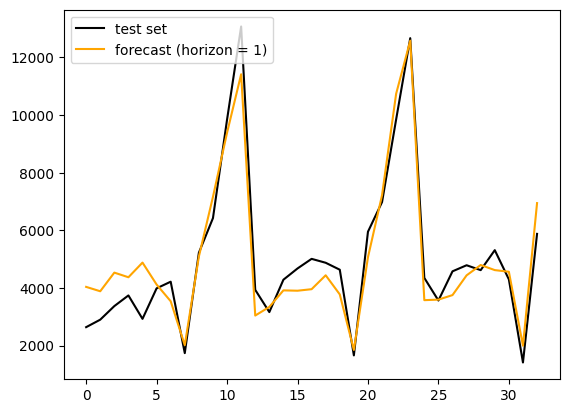

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

Modelimizi geliştirmek için biraz özellik mühendisliği yapabiliriz. Random forest'ı eğitmek için kullanılan veriye hareketli ortalamalar ekleyeceksiniz.

`df`'de 3 yeni sütun oluşturmaya çalışın: biri 12 pencereli `df[Sales]`'ın hareketli ortalaması, biri 3 pencereli, biri 2 pencereli. Bu, trendi izole etme ve algoritmanın onu öğrenmesini sağlama etkisi olacak. Bu verileri çizin.

In [ ]:
# Extract the trend using a well-chosen moving average
df2['ma_12'] = df2['Sales'].rolling(window=12).mean()
df2['ma_3'] = df2['Sales'].rolling(window=3).mean()
df2['ma_2'] = df2['Sales'].rolling(window=2).mean()

<AxesSubplot:xlabel='Month'>

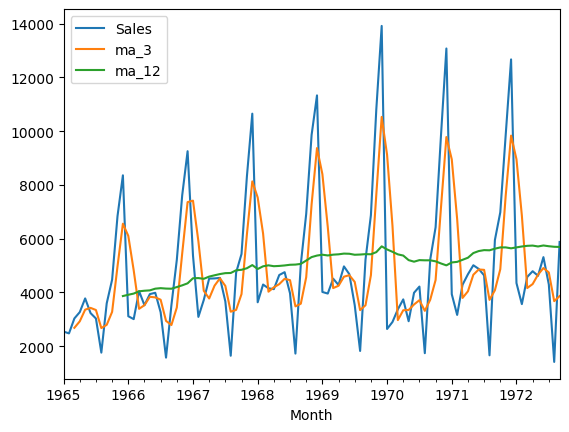

In [ ]:
df2[["Sales","ma_3", "ma_12"]].plot()

Ayrıca AR sürecini istatistiksel olarak optimize eden üstel hareketli ortalama (ipucu: 2, 3 ve 12 `halflife` ile `.ewm` metodu) kullanarak daha güçlü bir düzleştirme tahmincisi ekleyebilirsiniz. Bu verileri çizin.

In [ ]:
df2["ewma_2"] = df2["Sales"].ewm(halflife=2).mean()
df2["ewma_3"] = df2["Sales"].ewm(halflife=3).mean()
df2["ewma_12"] = df2["Sales"].ewm(halflife=12).mean()

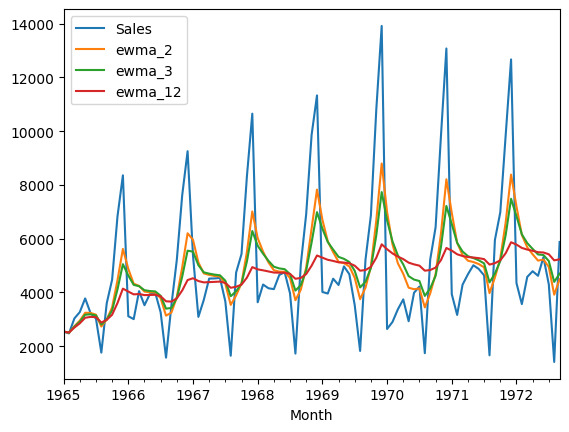

In [ ]:
df2[["Sales", "ewma_2", "ewma_3", "ewma_12"]].plot();

In [ ]:
random_forest = RandomForestRegressor(n_estimators=20, random_state=12)

features = [
    "ewma_2", "ewma_3", "ewma_12", "ma_2", "ma_3", "ma_12", "x_1",
    "x_2", "x_3", "x_4", "x_5", "x_6", "x_7", "x_8", "x_9", "x_10", "x_11", "x_12"
]

new_features = df2[features].fillna(0).values

results = evaluate_performance_month_prediction(
    df2["Sales"].values,
    test_indexes=test_indexes,
    predictor=random_forest,
    full_X = new_features
)


In [ ]:
results[2]

0.147890158319115

Daha iyi bir MAPE görmelisiniz!

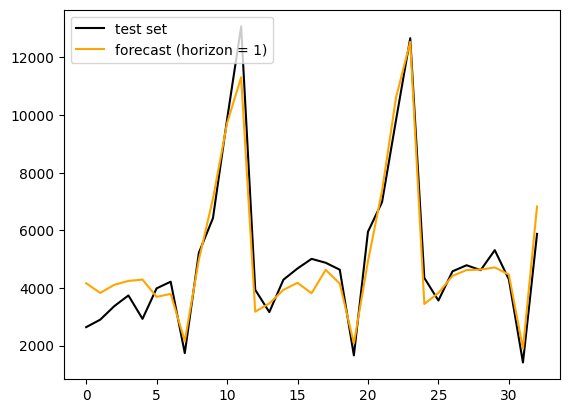

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend();

Her özelliğin önemine bakmaya çalışın. Ne buluyorsunuz?

In [ ]:
importances = random_forest.feature_importances_
pd.DataFrame(zip(importances, features)).sort_values(by=0, ascending=False)

,0,1
17,0.821873,x_12
3,0.062603,ma_2
7,0.020262,x_2
16,0.017454,x_11
1,0.014037,ewma_3
4,0.010594,ma_3
8,0.008481,x_3
15,0.007970,x_10
2,0.006503,ewma_12
11,0.005091,x_6


### Örneklem Dışı Tahmin Modelleri

Şimdi "örneklem dışı" tahminde SARIMA'yı yenmeye çalışalım.

👉 _Her tahmin ufku için bir model_ eğitin (`1`-ay ufkundan `len(y_test)` aya kadar)
👉 MAPE'yi değerlendirin ve SARIMA ile karşılaştırın

<AxesSubplot:>

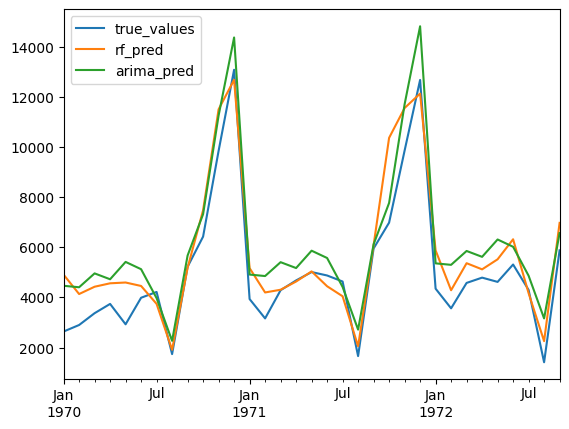

In [ ]:
# Initialize the random forest for predicting at each time step
random_forest_dict = {  # prediction horizon: model (1 is predicting at t+1, 2 at t+2...)
    i: RandomForestRegressor(n_estimators=20, random_state=0) for i in range(1, len(df_test) + 1)
}
# Do we have as much forests as there are test periods?
assert len(random_forest_dict) == df2_test.shape[0]
# Prepare data
X_train = new_features[:df2_train.shape[0], :]
y_train = df2.Sales[:df2_train.shape[0]]
X_test = new_features[df2_train.shape[0]:, :]
# Train models
for h in range(1, len(df_test) + 1):  # Setting the prediction horizon
    if h == 1:  # Dealing with exceptional behaviour when slicing [:-0,:]
        X_train_horizon = X_train
    else:
        X_train_horizon = X_train[:-(h - 1), :]
    y_train_horizon = y_train[(h - 1):]
    random_forest = random_forest_dict[h]
    random_forest.fit(X=X_train_horizon, y=y_train_horizon)
# Predicting test values with RF
x = X_test[0, :].reshape([1, X_train.shape[1]])
y_test_pred_rf = np.array([random_forest_dict[h].predict(X=x) for h in range(1, len(df_test) + 1)])[:, 0]
# Predicting test values with SARIMA
y_test_pred_arima = model.predict(n_periods=len(df_test), return_conf_int=False)
# Plot
pred_df = pd.DataFrame(
    {
        "true_values": df2.Sales[test_indexes],
        "rf_pred": y_test_pred_rf,
        "arima_pred": y_test_pred_arima,
    })
pred_df.plot()
